### Preparing the notebook

In [1]:
from utilities.helpers import check

check()

/home/selimsepthuit/anaconda3/envs/test-ml/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Tensorflow version 	= 1.7 [ok]
Keras version 		= 2.1 [ok]
OpenCV version 		= 3.3 [ok]

1 GPU detected


*Note that GPUs will only be used if Cuda and cuDNN are installed.*

In [2]:
import numpy as np
import cv2
from glob import glob
import matplotlib.pyplot as plt 
%matplotlib inline

In [3]:
from utilities.helpers import Time

In [4]:
# Jupyter will automaticaly reload libraries if they have been modified
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

---

# Table of Contents
---
1. **Data**
    - Loading and pre-processing the dataset
    - Visualizing the dataset
    
- **Training/Loading the model**
- **Evaluating the model**
- **Results**
    - Predictions
    - Generating the Class Activation Maps
- **Extending the dataset with images scraped from Google image**
- **Extending the dataset with Google Image Dataset - WIP**

# 1. Data
---

## Loading and pre-processing the dataset

The data used to train the classifier comes from the [INRIA person dataset](http://pascal.inrialpes.fr/data/human/). This dataset contains images with and without persons.

Let's download it (970MB):

In [ ]:
%%bash
wget ftp://ftp.inrialpes.fr/pub/lear/douze/data/INRIAPerson.tar
tar -xf INRIAPerson.tar
chmod -R 777 INRIAPerson/*

We can now load the data. This will:

- Transform images into a 4D tensor of shape `(samples_size, 224, 224, 3)` suitable for supplying to a Keras CNN
- Transform class labels into one hot encoded labels.
- Create a validation folder using 20% of the original training data (The INRIA person dataset originaly doesn't contain validation data)
- Balance the data: originaly, there are 1669 negatives and 900 positives which means that the model could reach an accuracy of 70% by always predicting negatives. We therefore do not load the excess of negatives.

In [5]:
from utilities import datasets

data = datasets.InriaPersonDataset("INRIAPerson")

100%|██████████| 238/238 [00:02<00:00, 82.11it/s]


The training tensors and labels can be accessed as follows:
```
data.X_train
data.y_train
```
Same goes for the validation and testing data (`X_valid`, `y_test` etc.)

## Visualizing the dataset

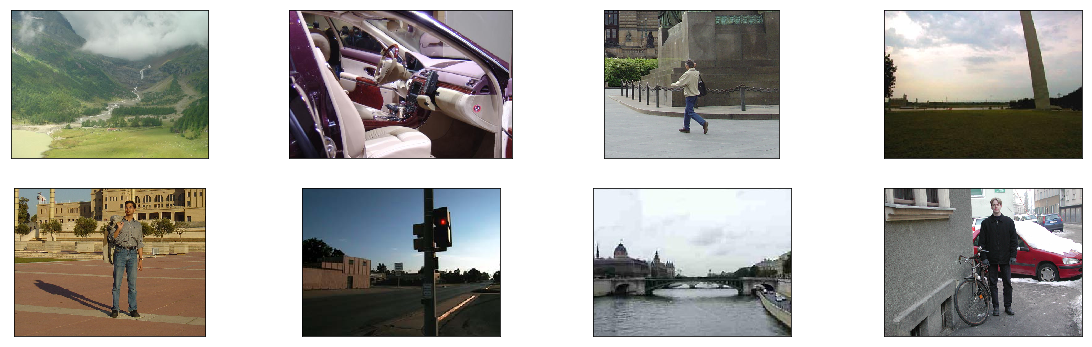

In [6]:
data.examples(sample="Test", number=8)

In [7]:
data.classes

['neg', 'pos']

In [8]:
data.statistics()

,neg,pos,Total
Classes,,,
Train,507,491,998
Valid,115,123,238
Test,223,288,511
,845,902,1747


# 2.  Training the model
---

### Model

In [9]:
from utilities.gapModels import MobileNetGAP

Let's load a `MobileNetGAP` model.

In [10]:
model = MobileNetGAP(nb_classes=len(data.classes))

#Or load it from a file
#model = MobileNetGAP(path='saved_model/mobilenet.h5')

This `model` can be used just as any **compiled** Keras model (`keras.models`). 

Its architecture is the following: 
- a "MobileNet" model, top not included, that ends with a GlobalAveragePooling layer, followed by a dense layer with as many neurones as there are classes in the dataset.
- the ConvNet layers of the model have been pretrained on the [ImageNet](http://image-net.org) dataset.

### Classifier

We now pass out model to a `Classifier` which can be used similarly to `sklearn` classifiers.

In [11]:
from utilities.classifier import Classifier

clf = Classifier(model, name='mobilenet') # once trained this model will be saved to 'saved_model/mobilenet.h5'

Instructions for updating:
Use the retry module or similar alternatives.


It will now be possible to train and reatrain this model, save it and load it, visualise its learning curves and test it. 

But the main feature this classifier brings is that it allows to easily output both the predictions and the **Class Activation Maps** (CAM) of the model, given a new image.

> Note: A classifier takes as an input models that are preferably built with a subclass of `AbstractModelGAP` (see `./utilities/gapModels.py`) as this makes the generation of CAMs easier.

Let's train the model on the INRIA person dataset. The MobileNet model has originally been pretrained on the [ImageNet](http://image-net.org) dataset so we perform transfert learning: we train the dense layer and retrain only the last two ConVnet layers (as the database is quite small).

In [12]:
clf.fit(data, epochs=100, batch_size=64, augmentation=True, verbose=0)

# 3.  Evaluating the model
---

Let's visualise the learning curves:

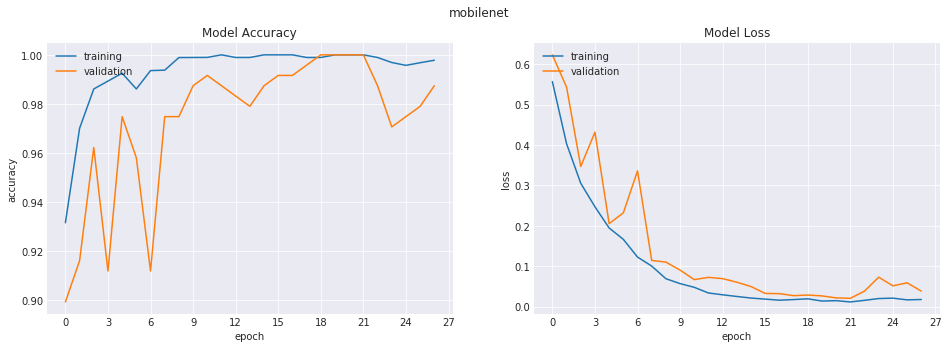

In [13]:
clf.learning_curves()

>These can also be visualized with Tensorboar:
```
tensorboard --logdir=./tensorboard_logs
```
The Tensorboard page can then be found on port `6006`  

We get the following results on the test set:

In [14]:
loss, acc = model.evaluate(data.X_test, data.y_test)

511/511 [==============================] - 1s 2ms/step


In [15]:
print("Loss     : {:.2%}\nAccuracy : {:.2%}".format(loss, acc))

Loss     : 9.06%
Accuracy : 98.24%


# 4. Results
---

Let's view the results for an exemple:

In [16]:
test_image_path = np.random.choice(glob("INRIAPerson/Test/*/*"))
test_image_path

'INRIAPerson/Test/neg/00001279.png'

In [17]:
test_img = cv2.imread(test_image_path, 1)

## Predictions

In [18]:
with Time() as runtime:
    # `decision=False` will output a probability vector
    # `decision=True`  will output 0 or 1
    prediction = clf.predict(test_img, decision=False) 

print("Prediction     :", prediction)
print('Execution time : {:.3f}ms'.format(1000*runtime()))

Prediction     : [0.9999708, 2.9187411e-05]
Execution time : 472.567ms


The model got the class right.

## Generating the Class Activation Maps

We can now view the regions that allowed the model to estimate the class probabilities:

Execution time : 433.936ms


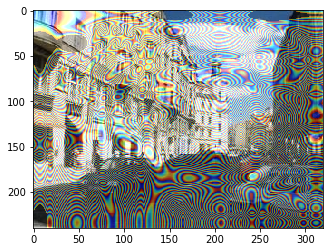

In [19]:
with Time() as runtime:
    cam, prediction = clf.cam(test_img, class_number=1)
    
plt.imshow(cam)
print('Execution time : {:.3f}ms'.format(1000*runtime()))

The CAM generation is quite fast with MobileNet!

Let's do that for a few other images:

In [20]:
def cam(clf):
    """
    cam for a random image
    """
    with Time() as runtime:
        test_image_path = np.random.choice(glob("INRIAPerson/Test/*/*"))
        test_img        = cv2.imread(test_image_path, 1)
        cam, prediction = clf.cam(test_img, class_number=1)
    
    print('Execution time : {:.3f}ms'.format(1000*runtime()))
    print("Prediction     :", data.classes[np.argmax(prediction)])
    plt.imshow(cam)

Execution time : 27.826ms
Prediction     : neg


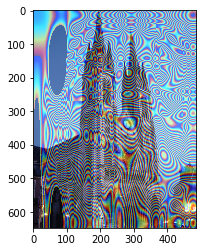

In [21]:
cam(clf)

Execution time : 38.759ms
Prediction     : pos


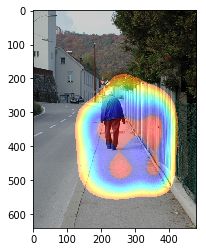

In [22]:
cam(clf)

# 5. Extending the dataset with images scraped from Google image

With the INRIA person dataset, the model overfits after a few iteration (~10). Moreover this dataset is limited: there are no close-up images for example and the model doesn't perform well when presented with the image of a face. 

Let's add more images to this dataset using [images scraped from Google image](https://github.com/hardikvasa/google-images-download).

In [23]:
from utilities import datasets

In [24]:
data_gi = datasets.GoogleImageScrapedDataset("googleImage")

In [ ]:
for keyword in ["room", "empty street", "animals", "forest", "house", "ghost town", "kitchen", "empty corridor"]:
    data_gi.fillClass(class_name="neg", sample_size=100, keyword=keyword, valid=0.2, test=0.2)
    
for keyword in ["woman", "man", "room with people", "person in street", "people in webcam", "girl", "boy", "dancer"]:
    data_gi.fillClass(class_name="pos", sample_size=100, keyword=keyword, valid=0.2, test=0.2)

In [25]:
data_gi.load()

100%|██████████| 285/285 [00:03<00:00, 78.45it/s]


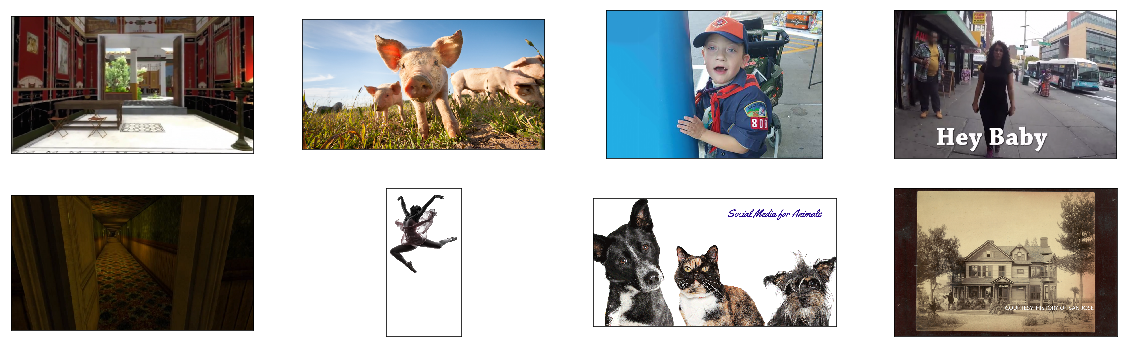

In [26]:
data_gi.examples(sample="Train", number=8)

In [27]:
data_gi.statistics()

,neg,pos,Total
Classes,,,
Train,416,414,830
Valid,147,138,285
Test,144,150,294
,707,702,1409


Let's now add to this new dataset the images from the INRIA person dataset.

In [28]:
data_gi.merge(data)

In [29]:
data_gi.statistics()

,neg,pos,Total
Classes,,,
Train,923,905,1828
Valid,262,261,523
Test,367,438,805
,1552,1604,3156


### Training

In [30]:
model_gi = MobileNetGAP(nb_classes=len(data.classes))

In [31]:
clf_gi = Classifier(model_gi, name='mobilenet_with_gi_data')

clf_gi.fit(data_gi, epochs=50, batch_size=64, augmentation=True, verbose=0)

### Evaluating

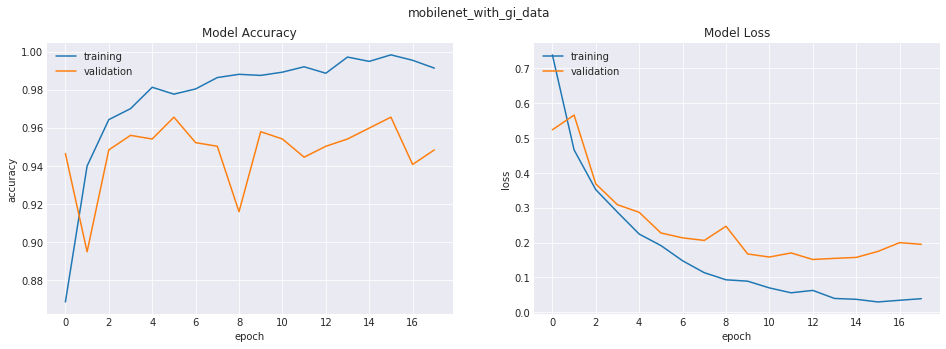

In [32]:
clf_gi.learning_curves()

In [33]:
loss, acc = model_gi.evaluate(data.X_test, data.y_test)
print("Loss     : {:.2%}\nAccuracy : {:.2%}".format(loss, acc))

511/511 [==============================] - 1s 2ms/step
Loss     : 13.36%
Accuracy : 96.67%


In [40]:
def cam(clf):
    """
    cam for a random image
    """
    with Time() as runtime:
        test_image_path = np.random.choice(glob("INRIAPerson/Test/*/*"))
        test_img        = cv2.imread(test_image_path, 1)
        cam, prediction = clf.cam(test_img, class_number=1)
    
    print('Execution time : {:.3f}ms'.format(1000*runtime()))
    print("Prediction     :", data.classes[np.argmax(prediction)])
    plt.imshow(cam)

Execution time : 33.010ms
Prediction     : neg


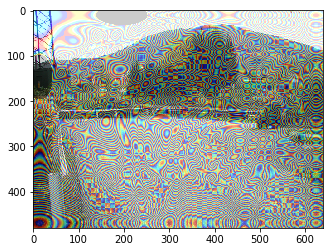

In [41]:
cam(clf_gi)

Execution time : 39.895ms
Prediction     : pos


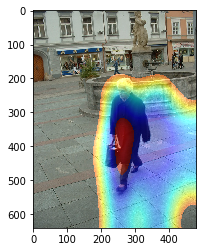

In [42]:
cam(clf_gi)

Execution time : 22.867ms
Prediction     : neg


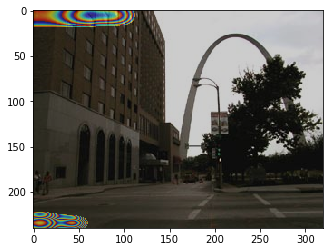

In [43]:
cam(clf_gi)

Execution time : 88.442ms
Prediction     : pos


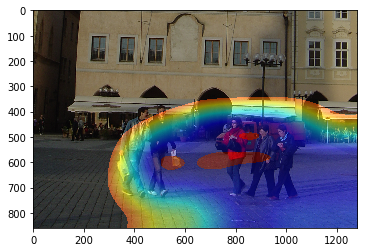

In [49]:
cam(clf_gi)

Execution time : 62.825ms
Prediction     : pos


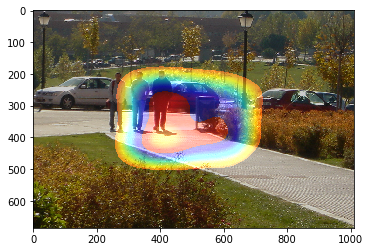

In [51]:
cam(clf_gi)

Execution time : 46.599ms
Prediction     : pos


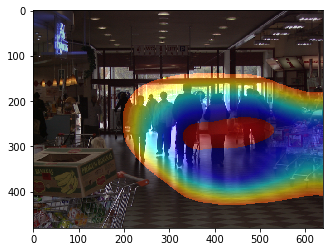

In [54]:
cam(clf_gi)

Execution time : 33.995ms
Prediction     : neg


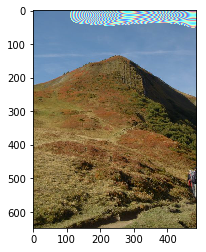

In [55]:
cam(clf_gi)

# 6. Extending the dataset with Google Image Dataset - WIP

*Work In Progress*

In [ ]:
import pandas as pd

In [ ]:
complete_dataframe = pd.read_csv("2017_11/train/annotations-human.csv")

In [ ]:
with open("2017_11/classes-bbox.txt", 'r') as classes_file:
    classes = classes_file.read().splitlines()

In [ ]:
dataframe = complete_dataframe.head(100000)

In [ ]:
dataframe.dtypes

In [ ]:
# Droping the 'Source' column
dataframe = dataframe.drop(['Source'], axis=1)

# Selecting only the rows encoding a label that has been recognized
dataframe = dataframe[(dataframe.Confidence == 1)]

# Selecting only the rows encoding a label that is part of the 601 classes-bbox
dataframe = dataframe[dataframe.LabelName.isin(classes)]

# Droping the 'Confidence' column
dataframe = dataframe.drop(['Confidence'], axis=1)

dataframe['LabelName'] = dataframe['LabelName'].astype('category')

dataframe.head()

from collections import defaultdict

ImageIDs = dict((ImageID,np.zeros(len(classes))) for ImageID in list(dataframe['ImageID'].unique()))

classes_dict = dict((classe, index) for index, classe in enumerate(classes))

len(ImageIDs)

(len(ImageIDs), len(classes))

with Time() as t:
    for _, row in dataframe.iterrows():
        ImageID   = row['ImageID']
        LabelName = row['LabelName']
        ImageIDs[ImageID][classes_dict[LabelName]] = 1

In [ ]:
ImageIDs["000002b66c9c498e"]

In [ ]:
image_ids = ImageIDs.keys()
y_train = list(ImageIDs.values())

---





In [ ]:
classes_file_path = "2017_11/classes-bbox.txt"

with open(classes_file_path, 'r') as classes_file:
    classes = classes_file.read().splitlines()
    
# keys = class encoding, values = index in 0...600
classes_dict = dict((classe, index) for index, classe in enumerate(classes))

In [ ]:
import pandas as pd
import numpy  as np

In [ ]:
# all the classes
classes_file_path = "2017_11/classes-bbox.txt"

with open(classes_file_path, 'r') as classes_file:
    classes = classes_file.read().splitlines()

In [ ]:
def load_targets(annotation_csv_path, classes):
    """
    load only human and non human targets
    """
    # keys = class encoding, values = index in 0...600
    classes_dict = dict((classe, index) for index, classe in enumerate(classes))
    
    dataframe = pd.read_csv(annotation_csv_path).head(10000)
    
    # Droping the 'Source' column
    dataframe = dataframe.drop(['Source'], axis=1)

    # Selecting only the rows encoding a label that has been recognized and that is part of the 601 classes-bbox
    dataframe = dataframe[(dataframe.Confidence == 1) & (dataframe.LabelName.isin(classes))]

    # Droping the 'Confidence' column
    dataframe = dataframe.drop(['Confidence'], axis=1)
    
    # keys = image id, values = classes 
    targets = dict((ImageID,np.zeros(len(classes))) for ImageID in list(dataframe['ImageID'].unique()))

    for _, row in dataframe.iterrows():
        ImageID   = row['ImageID']
        LabelName = row['LabelName']
        targets[ImageID][classes_dict[LabelName]] = 1
        
    return targets

In [ ]:
classes_human_or_not = ['/m/0dgw9r', "neg"]

In [ ]:
annotation_csv_path = "2017_11/train/annotations-human.csv"

targets = load_targets("2017_11/train/annotations-human.csv", classes_human_or_not)

In [ ]:
targets